In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
# from helper_functions import set_seeds

import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
import os
import zipfile
from pathlib import Path
import requests
import os

In [3]:
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['keyboard','mobile','mouse','tv']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

In [6]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 4]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [7]:
# Setup directory paths to train and test images
train_dir = 'C:/Users/SHRIKAR/Downloads/major project image classification using yolo v8/ewaste dataset/train'
test_dir = 'C:/Users/SHRIKAR/Downloads/major project image classification using yolo v8/ewaste dataset/val'

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [8]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [9]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [10]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [11]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results


In [12]:
# from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5644 | train_acc: 0.8404 | test_loss: 0.2573 | test_acc: 0.9245
Epoch: 2 | train_loss: 0.1397 | train_acc: 0.9699 | test_loss: 0.1753 | test_acc: 0.9505
Epoch: 3 | train_loss: 0.0975 | train_acc: 0.9833 | test_loss: 0.1423 | test_acc: 0.9609
Epoch: 4 | train_loss: 0.0760 | train_acc: 0.9877 | test_loss: 0.1216 | test_acc: 0.9688
Epoch: 5 | train_loss: 0.0616 | train_acc: 0.9911 | test_loss: 0.1139 | test_acc: 0.9714
Epoch: 6 | train_loss: 0.0494 | train_acc: 0.9933 | test_loss: 0.1054 | test_acc: 0.9714
Epoch: 7 | train_loss: 0.0425 | train_acc: 0.9967 | test_loss: 0.1024 | test_acc: 0.9688
Epoch: 8 | train_loss: 0.0354 | train_acc: 0.9978 | test_loss: 0.0983 | test_acc: 0.9688
Epoch: 9 | train_loss: 0.0305 | train_acc: 0.9978 | test_loss: 0.0972 | test_acc: 0.9688
Epoch: 10 | train_loss: 0.0277 | train_acc: 0.9978 | test_loss: 0.0975 | test_acc: 0.9688


In [33]:
import os
import torch

# Define the directory path
directory_path = "C:/Users/SHRIKAR/Downloads/Image-Classification-Using-Vision-transformer/models"

# Create the directory if it doesn't exist
os.makedirs(directory_path, exist_ok=True)

# Define the file path where you want to save the model
model_save_path = os.path.join(directory_path, "vision_transformer_image_classifier.pth")

# Save the model state dictionary
torch.save(pretrained_vit.state_dict(), model_save_path)

print(f"Model saved successfully at {model_save_path}")


Model saved successfully at C:/Users/SHRIKAR/Downloads/Image-Classification-Using-Vision-transformer/models\vision_transformer_image_classifier.pth


In [34]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def evaluate(model, dataloader, device):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(torch.argmax(model(X), dim=1).cpu().numpy())
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

In [36]:
# Assuming you have already trained your model and have the test dataloader and device set up
evaluate(model=pretrained_vit, 
         dataloader=test_dataloader_pretrained, 
         device=device)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        93
           1       0.99      0.91      0.95        93
           2       0.98      1.00      0.99        93
           3       0.91      0.99      0.95        93

    accuracy                           0.97       372
   macro avg       0.97      0.97      0.97       372
weighted avg       0.97      0.97      0.97       372

Confusion Matrix:
[[90  0  1  2]
 [ 0 85  1  7]
 [ 0  0 93  0]
 [ 0  1  0 92]]


In [42]:
!pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ---------------------------------------- 1.4/1.4 MB 5.1 MB/s eta 0:00:00


In [123]:
from pathlib import Path
import torch
import torchvision.transforms as transforms  # Added import

# Define pretrained_vit and pretrained_vit_transforms
pretrained_vit = pretrained_vit  # Define your ViT model instance here
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# Update the transformation with the correct mean and standard deviation
pretrained_vit_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Define class_names
class_names = ['keyboard', 'mobile', 'mouse', 'tv']

test_dir = 'C:/Users/SHRIKAR/Downloads/major project image classification using yolo v8/ewaste dataset/val'
directory_path = Path(test_dir)
extensions = ('.jpg', '.jpeg', '.png')

test_data_paths = []
for file_path in directory_path.glob('**/*'):
    if file_path.is_file() and file_path.suffix.lower() in extensions:
        test_data_paths.append(file_path)

print(f"Found {len(test_data_paths)} images")
test_data_paths[:5]

import pathlib
from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: transforms.Compose,  # Change this to transforms.Compose
                   class_names: List[str], 
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    pred_list = []
    
    for path in tqdm(paths):
        pred_dict = {}

        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
    
        start_time = timer()
    
        img = Image.open(path)
    
        # Convert the image to RGB format if it has an alpha channel
        if img.mode == 'RGBA':
            img = img.convert('RGB')
    
        transformed_image = transform(img).unsqueeze(0).to(device) 
    
        model.to(device)
        model.eval()
    
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
        
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)
    
            pred_dict["correct"] = class_name == pred_class

        pred_list.append(pred_dict)
    return pred_list

# Assuming pretrained_vit, pretrained_vit_transforms, and class_names are defined elsewhere
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=pretrained_vit,
                                     transform=pretrained_vit_transforms,
                                     class_names=class_names,
                                     device=device)


Found 372 images


  0%|          | 0/372 [00:00<?, ?it/s]

In [124]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,C:\Users\SHRIKAR\Downloads\major project image...,keyboard,0.9987,keyboard,0.5078,True
1,C:\Users\SHRIKAR\Downloads\major project image...,keyboard,0.9994,keyboard,0.5101,True
2,C:\Users\SHRIKAR\Downloads\major project image...,keyboard,0.9986,keyboard,0.5167,True
3,C:\Users\SHRIKAR\Downloads\major project image...,keyboard,0.9964,keyboard,0.5106,True
4,C:\Users\SHRIKAR\Downloads\major project image...,keyboard,0.9868,keyboard,0.4999,True


In [125]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

True     361
False     11
Name: correct, dtype: int64

In [126]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.7276 seconds


In [137]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(vit_test_pred_df):
    # Extract required fields from the DataFrame
    true_labels = vit_test_pred_df['class_name']
    pred_labels = vit_test_pred_df['pred_class']
    
    # Get unique class names from the DataFrame
    class_names = np.unique(np.concatenate((true_labels, pred_labels), axis=None))

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=class_names)

    # Plot the confusion matrix as a colorful image
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


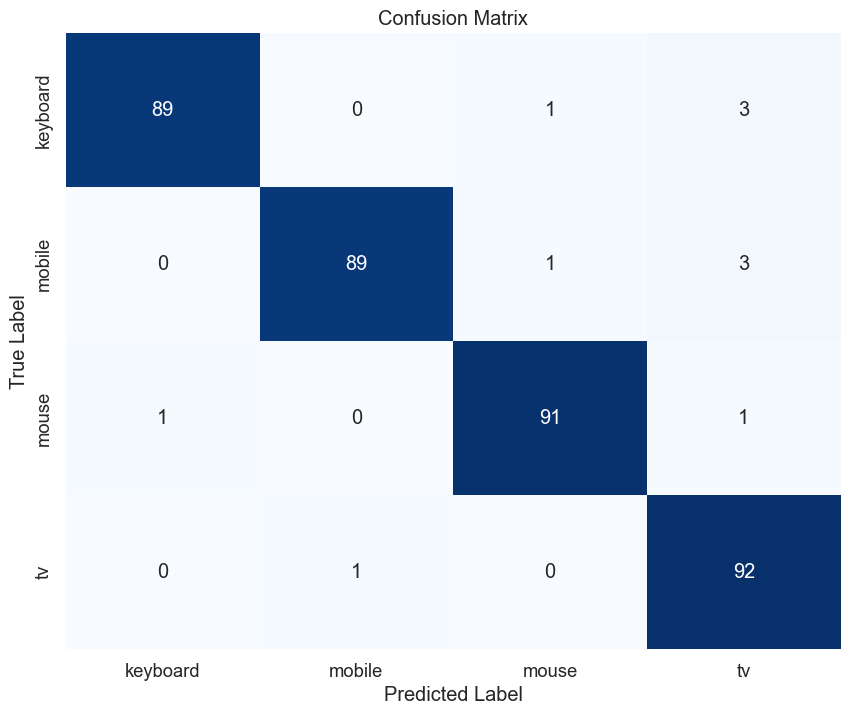

In [138]:
plot_confusion_matrix(vit_test_pred_df)

pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


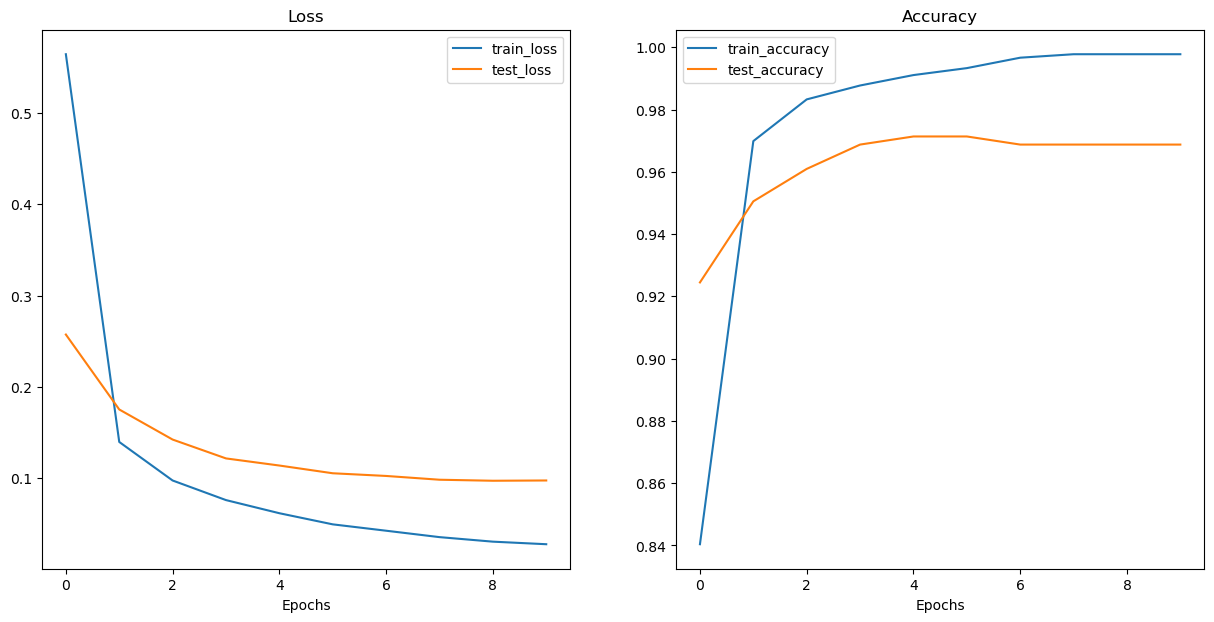

In [20]:
import os
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

save_dir = 'C:/Users/SHRIKAR/Downloads/Image-Classification-Using-Vision-transformer/metric_curves'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the plot to the directory
plt.savefig(os.path.join(save_dir, 'loss_accuracy_curves.png'))

## That's the power of transfer learning!

We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

# Let's make Prediction:

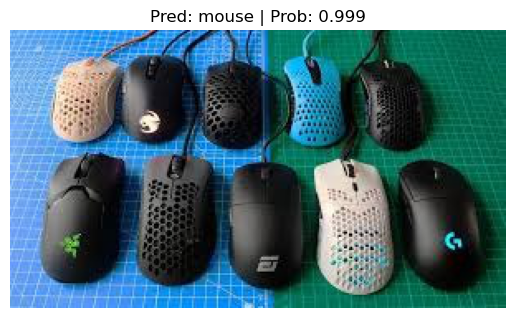

In [12]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "C:/Users/SHRIKAR/Downloads/images.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

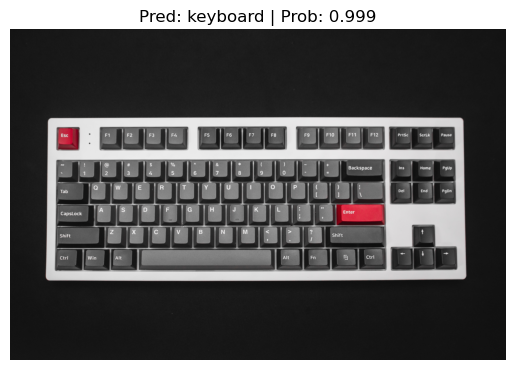

In [13]:
# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "C:/Users/SHRIKAR/Downloads/jan-loyde-cabrera-p5rgceFiOH0-unsplash.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [146]:
import torch
import torchvision.models as models
import torch.nn as nn

def create_vit_model(class_names: list, 
                     seed: int = 42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        class_names (list): List of class names.
        seed (int, optional): Random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model. 
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False
    
    num_classes = len(class_names)

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, 
                                          out_features=num_classes))
    
    return model, transforms


In [160]:
import torch
import torchvision
import torch.nn as nn
import os

# Define the directory path where the model is saved
directory_path = "C:/Users/SHRIKAR/Downloads/Image-Classification-Using-Vision-transformer/models/"

# Define the file path where the model is saved
model_save_path = os.path.join(directory_path, "vision_transformer_image_classifier.pth")

# Define the number of output classes
num_classes = 4

# Define the create_vit_model function
def create_vit_model(num_classes: int = 4, seed: int = 42):
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768,  # keep this the same as original model
                                           out_features=num_classes))  # update to reflect target number of classes

    return model, transforms

# Create an instance of the VisionTransformer model with the correct number of output classes
model, _ = create_vit_model(num_classes=num_classes)

# Load the saved model state dictionary
# Load the saved model state dictionary
state_dict = torch.load(model_save_path)

# Create a new dictionary and copy the state dictionary's keys and values to the new dictionary
modified_state_dict = {}
for key, value in state_dict.items():
    modified_key = key.replace("heads.weight", "heads.0.weight").replace("heads.bias", "heads.0.bias")
    modified_state_dict[modified_key] = value

# Load the modified state dictionary into the model
model.load_state_dict(modified_state_dict, strict=False)


# Ensure the model is in evaluation mode
model.eval()

print("Model loaded successfully.")


Model loaded successfully.


In [153]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 4]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

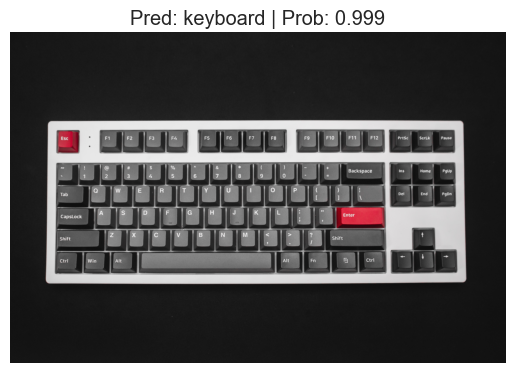

In [161]:
# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "C:/Users/SHRIKAR/Downloads/jan-loyde-cabrera-p5rgceFiOH0-unsplash.jpg"

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

In [2]:
!pip install streamlit streamlit_lottie

     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     -------------------------- ------------- 41.0/61.0 kB 1.9 MB/s eta 0:00:01
     --------------------------------- ------ 51.2/61.0 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 61.0/61.0 kB 651.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB 5.9 MB/s eta 0:00:02
   --- ------------------------------------ 0.7/8.1 MB 8.9 MB/s eta 0:00:01
   ---- ----------------------------------- 0.9/8.1 MB 7.0 MB/s eta 0:00:02
   ----- ---------------------------------- 1.1/8.1 MB 6.3 MB/s eta 0:00:02
   ------ --------------------------------- 1.3/8.1 MB 5.8 MB/s eta 0:00:02
   ------- -------------------------------- 1.4/8.1 MB 5.4 MB/s eta 0:00:02
   -------- ------------------------------- 1.6/8.1 MB 5.0 MB/s eta 0:00:02
   -------- ------------------------------- 1.8/8.1 MB 5.0 MB/s eta 0:00:02
   --------

In [ ]:
!streamlit run appCopy1.py